# IBM Dynamical Decoupling Optimizations with Superstaq - Advanced

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Infleqtion/client-superstaq/blob/main/docs/source/optimizations/ibm/ibmq_dd.ipynb) [![Launch Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Infleqtion/client-superstaq/HEAD?labpath=docs/source/optimizations/ibm/ibmq_dd.ipynb)

[Dynamical decoupling (DD)](https://arxiv.org/abs/quant-ph/9803057) is an error mitigation technique used to suppress noise added to computation from system-environment interaction (i.e. decoherence error). DD is implemented during algorithm execution by adding special gate sequences that are equal to the identity operation in periods of qubit idling. Examples of DD sequences include XX, XY4, XY8, and UDD, among others.

Below is a brief tutorial on Superstaq dynamical decoupling optimizations for the IBM family of superconducting quantum devices. In the examples below, the CPMG sequence (XX) will be used.

Many [research articles](https://arxiv.org/abs/2207.03670) can be found that describe the variations and benefits of DD. For more information about IBM Quantum, visit their website [here](https://quantum-computing.ibm.com/).

There are many possible ways to determine how and where to place DD sequences within an idling window. We refer to these approaches as strategies. Superstaq supports the following dynamical decoupling strategies:

*Dynamic (default)*: Spaces pulses in a sequence based on sequence length, oblivious to sequences placed on neighboring qubits. <br>
*Static*: Inserts as many pulses in an idling duration as possible (not recommended for most circuits). <br>
*Static_context_aware*: Spacing each sequence's gates based on a specific value. <br>

All of the above strategies, by default, use the CPMG sequence.
Users have the ability to specify the dynamical decoupling strategy desired via the keyword argument `dd_strategy`.


## Imports and API Token

This example tutorial notebook uses `qiskit-superstaq`, our Superstaq client for Qiskit; you can try it out by running `pip install qiskit-superstaq`.

In [1]:
# Required Superstaq imports
try:
    import qiskit
    from qiskit import QuantumCircuit
    import qiskit_ibm_provider
    import qiskit_superstaq as qss
except ImportError:
    print("Installing qiskit-superstaq...")
    %pip install --quiet 'qiskit-superstaq[examples]'
    print("Installed qiskit-superstaq.")
    print("You may need to restart the kernel to import newly installed packages.")
    import qiskit
    from qiskit import QuantumCircuit
    import qiskit_ibm_provider
    import qiskit_superstaq as qss

# Optional imports
import os  # used if setting a token as an environment variable

To interface Superstaq via Qiskit, we must first instantiate a provider in `qiskit-superstaq` with `SuperstaqProvider()`. We then supply a Superstaq API token (or key) by either providing the API token as an argument of `qss.SuperstaqProvider()` or by setting it as an environment variable (see more details [here](https://superstaq.readthedocs.io/en/latest/get_started/basics/basics_qss.html#Set-up-access-to-Superstaq%E2%80%99s-API)).

In [2]:
# Get the qiskit superstaq provider for Superstaq backend
# Provide your api key to the using the "api_key" argument if
# SUPERSTAQ_API_KEY environment variable is not set.
# If SUPERSTAQ_API_KEY environment variable set, use os.environ["SUPERSTAQ_API_KEY"].
provider = qss.SuperstaqProvider()

This notebook will target IBM's 16-qubit Guadalupe device.

In [3]:
backend = provider.get_backend("ibmq_guadalupe_qpu")

## Example 1: Circuit Compilation and DD Optimization with Superstaq

In this example, we will be using a circuit with a 4 qubit GHZ state, which we generate below:

In [4]:
n_qubits = 4
ghz = qiskit.QuantumCircuit(n_qubits, n_qubits)
ghz.h(0)
for i in range(n_qubits - 1):
    ghz.cx(i, i + 1)
ghz.measure_all()

We can draw the circuit using `qiskit`:

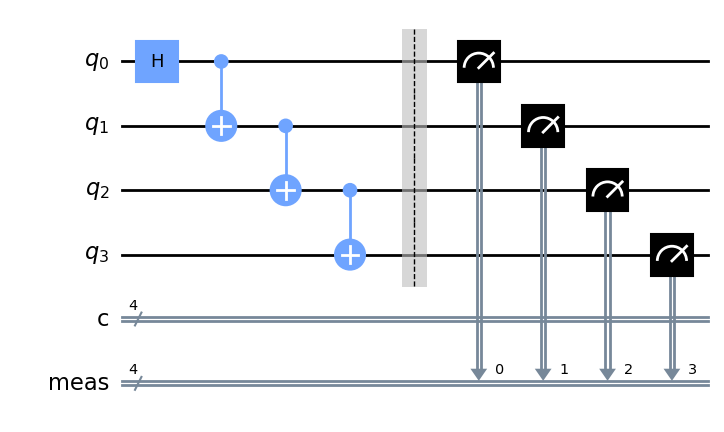

In [5]:
ghz.draw("mpl")

Next, we will compile the logical circuit with Qiskit. Qiskit compilation will serve as a baseline that we use to evaluate Superstaq's error mitigation techniques.

In [ ]:
qiskit_ibm_provider.IBMProvider.save_account(
    overwrite=True,
    token="a70858d1df8622e9842fe6d8b45b42bbae5873c308ac4215bc9bc412d4c541f9a11264a2f587935365fa339a9d376d9908327bbdd6150c85a0601e7a4f373cc6",
)
ibm_provider = qiskit_ibm_provider.IBMProvider()
ibm_backend = ibm_provider.get_backend("ibmq_guadalupe")

qiskit_ghz_4_optimized = qiskit.transpile(ghz, ibm_backend, optimization_level=3)
qiskit_ghz_4_optimized.draw("mpl", fold=-1, idle_wires=False, justify="right")

Superstaq compilation transforms the circuit so that it uses optimized instructions. Here, on qubits with long idling durations we insert XX gates using our basic `static` strategy.

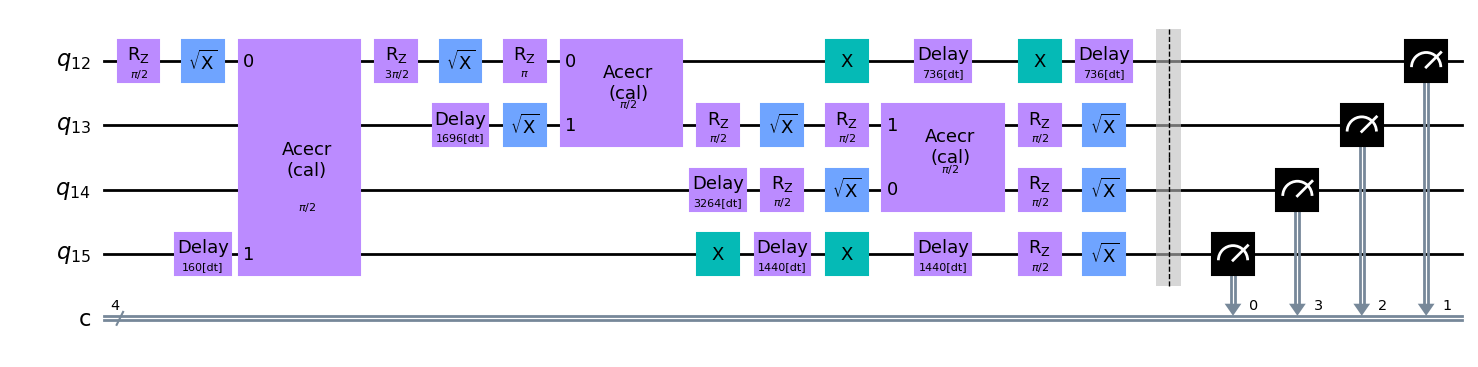

In [16]:
ss_ghz_4_optimized_static = backend.compile(ghz, dd_strategy="static", dynamical_decoupling=True)
ss_ghz_4_optimized_static.pulse_gate_circuit.draw("mpl", fold=-1, idle_wires=False, justify="right")

Below, we insert DD using the default `dynamic` strategy.

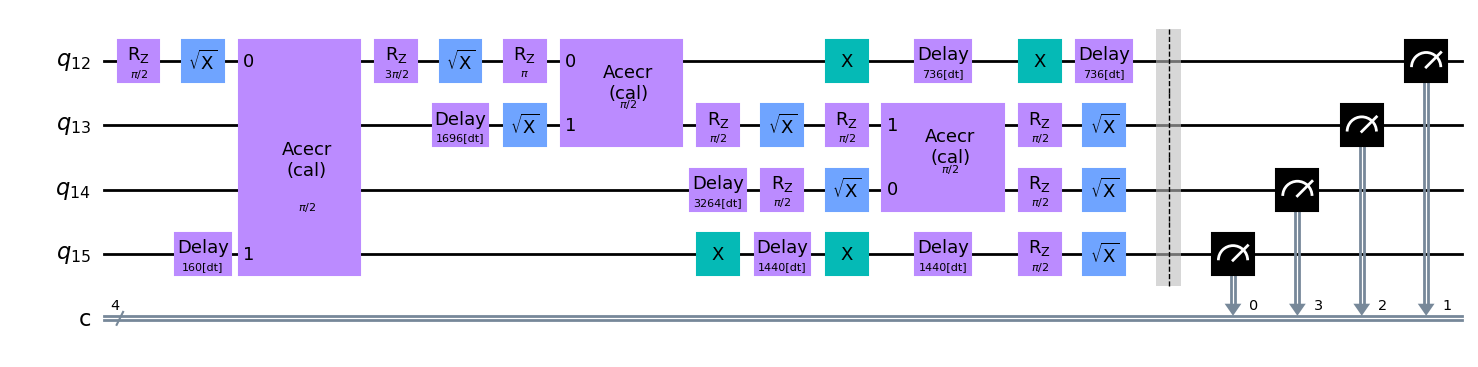

In [17]:
ss_ghz_4_optimized_dynamic = backend.compile(ghz, dynamical_decoupling=True)
ss_ghz_4_optimized_dynamic.pulse_gate_circuit.draw(
    "mpl", fold=-1, idle_wires=False, justify="right"
)

And now, we compile with DD using our third strategy `static_context_aware`.

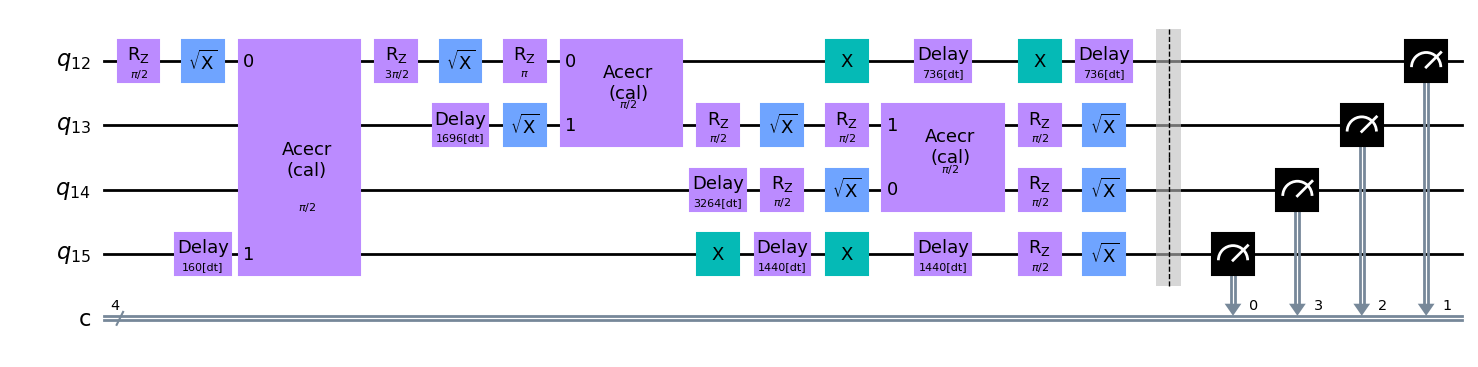

In [18]:
ss_ghz_4_optimized_static_context_aware = backend.compile(
    ghz, dd_strategy="static_context_aware", dynamical_decoupling=True
)
ss_ghz_4_optimized_static_context_aware.pulse_gate_circuit.draw(
    "mpl", fold=-1, idle_wires=False, justify="right"
)